# Import libraries

In [1]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt

### Other dependencies ###
from PIL import Image
from sklearn.preprocessing import OneHotEncoder

### Tensorflow dependencies ###
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy

### Some constants ###
pnet_weights = 'weights/pnet.weights.hdf5'
# train_dir = "/home/minhhieu/Desktop/Hieu/datasets/GTSDB/TrainIJCNN2013/TrainIJCNN2013"
train_dir = "/home/minhhieu/Desktop/Hieu/datasets/RoadSignDetection/images"
# train_dir = "/home/minhhieu/Desktop/Hieu/datasets/WIDER_train/WIDER_train/images"
test_dir = "/home/minhhieu/Desktop/Hieu/datasets/GTSDB/TestIJCNN2013/TestIJCNN2013Download"

# Load and explore dataset

[INFO] From images to ground truth ... 
[INFO] Converting to raw dataset ... 
[INFO] 1244 samples loaded ... 


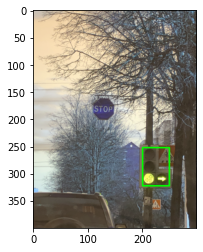

In [2]:
def load_raw_dataset(dataset_dir, gt_file, delimiter=';', max_n_samples=5000):
    '''
        This function will take in a dataset directory with ppm images (according to the DTSDB dataset)
        then it will return a list where each element is a list of 3 items. First item is the image, the
        second item is the bounding box and the last is the class ID.
        
        Params :
            @dataset_dir : Dataset directory.
            @gt_file : The file that consists of ground truth annotation in the format
            <img_pth>;<left>;<top>;<right>;<bottom>;<class_idx>.
            @delimiter : The separator of each item in each line of the ground truth file
            
        Returns :
            raw_dataset : list of elements [<cv2_img>, <gt_bbox>, <class_idx>]
    '''
    gt_abs_path = os.path.join(dataset_dir, gt_file)
    lines = open(gt_abs_path, 'r').readlines()
    
    print('[INFO] From images to ground truth ... ')
    images_to_gt = [[x.strip().split(delimiter)[0],   # Image path
                     x.strip().split(delimiter)[1:5], # Bbox regression ground truth
                     x.strip().split(delimiter)[5]]   # The class index
                    for x in lines]
    
    print('[INFO] Converting to raw dataset ... ')
    raw_dataset = [[cv2.imread(os.path.join(dataset_dir, x[0])),
                    np.array(x[1]).astype('int'),
                    int(x[2])]
                  for x in images_to_gt[:max_n_samples]]
    
    print(f'[INFO] {len(raw_dataset)} samples loaded ... ')
    
    return raw_dataset
    
raw_dataset = load_raw_dataset(train_dir, 'gt.txt')

### Visualize sample data ###
img = raw_dataset[1][0].copy()
bbox = raw_dataset[1][1]
x1, y1, x2, y2 = bbox
img = cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), 2)
plt.imshow(img)
plt.show()

### Generating negative samples (samples without traffic signs)

[INFO] 1244 negative samples generated ... 


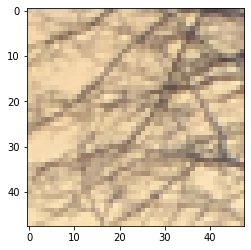

In [3]:
def generate_neg_samples(raw_dataset, crop_size=(48, 48)):
    '''
        This function will generate croppings of fixed size without any traffic sign
        and return those croppings with dummy bbox ground truth
        
        Params:
            @raw_dataset : The raw dataset formated similarly above
            @crop_size : The fixed cropping size
            
        Return:
            neg_samples : A list in format [<crop_img>,<dummy_bbox>,0]
    '''
    neg_samples = []
    for img, bbox, class_id in raw_dataset:
        height, width = img.shape[:2]
        x1, y1, x2, y2 = bbox
        range_x = ((0, max(x1 - crop_size[0], 0)), (min(x2 + crop_size[0], width), width))
        range_y = ((0, max(y1 - crop_size[1], 0)), (min(y2 + crop_size[1], height), height))
        
        ### Generate a random x,y coordinates ###
        x = random.choice([random.randint(range_x[0][0], range_x[0][1]), 
                           random.randint(range_x[1][0], range_x[1][1])])
        y = random.choice([random.randint(range_y[0][0], range_y[0][1]), 
                           random.randint(range_y[1][0], range_y[1][1])])
        
        # regenerate if cropping does not satisfy the size requirements
        while(width - x < crop_size[0] or height - y < crop_size[1]):
            x = random.choice([random.randint(range_x[0][0], range_x[0][1]), 
                           random.randint(range_x[1][0], range_x[1][1])])
            y = random.choice([random.randint(range_y[0][0], range_y[0][1]), 
                           random.randint(range_y[1][0], range_y[1][1])])
        
        crop = img[y:y+crop_size[1], x:x+crop_size[0]]
        neg_samples.append([crop, np.array([0,0,0,0]), 0])
        
    print(f'[INFO] {len(neg_samples)} negative samples generated ... ')
    return np.array(neg_samples)

neg_samples = generate_neg_samples(raw_dataset, crop_size=(48,48))
plt.imshow(neg_samples[1][0].copy())
plt.show()

### Generate positive samples (samles with traffic signs)

[INFO] 1244 positive samples generated ... 


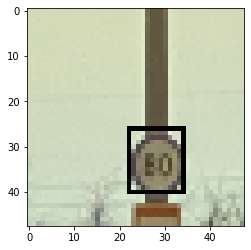

In [4]:
def generate_pos_samples(raw_dataset, pad_range=(10, 100), img_size=48):
    '''
        This function will generate croppings with traffic signs
        and return those croppings with bbox ground truth
        
        Params:
            @raw_dataset : The raw dataset formated similarly above
            @pad_range : The pad range around the ground truth bounding box
            
        Return:
            pos_samples : A list in format [<crop_img>,<bbox>,1]
    '''
    pos_samples = []
    for img, bbox, class_id in raw_dataset:
        height, width = img.shape[:2]
        x1, y1, x2, y2 = bbox
        pad_x1 = min(x1, random.randint(pad_range[0], pad_range[1]))
        pad_x2 = min(width - x2, random.randint(pad_range[0], pad_range[1]))
        pad_y1 = min(y1, random.randint(pad_range[0], pad_range[1]))
        pad_y2 = min(height - y2, random.randint(pad_range[0], pad_range[1]))
        
        crop = img[y1 - pad_y1:y2 + pad_y2, x1 - pad_x1:x2 + pad_x2]
        h, w = crop.shape[:2]
        
        gt = np.array([pad_x1, pad_y1, pad_x1 + x2 - x1, pad_y1 + y2 - y1])
        gt[2] = gt[2] - gt[0] # Calculates width
        gt[3] = gt[3] - gt[1] # Calculates height
        gt = np.multiply(gt, np.array([1/w, 1/h, 1/w, 1/h])).astype('float32')
        
        crop = cv2.resize(crop, (img_size, img_size))
        pos_samples.append([crop, gt, 1])
        
    print(f'[INFO] {len(pos_samples)} positive samples generated ... ')
    return np.array(pos_samples)

pos_samples = generate_pos_samples(raw_dataset, pad_range=(5, 50), img_size=48)

img, gt, label = pos_samples[6]
img = img.copy()
h, w = img.shape[:2]
x1, y1, w, h = np.multiply(gt, np.array([w,h,w,h])).astype('int')

img = cv2.rectangle(img, (x1, y1), (x1+w, y1+h), 2)
plt.imshow(img)
plt.show()

### Combine negative and positive samples to form training dataset

In [5]:
# Concatenate two groups and shuffle
train_dataset = np.concatenate([pos_samples, neg_samples])
np.random.shuffle(train_dataset)

train_images = np.array([x[0] for x in train_dataset])
train_bboxes = np.array([x[1] for x in train_dataset])
train_labels = OneHotEncoder().fit_transform(train_dataset[:,2].reshape(-1, 1)).toarray()

train_bboxes = train_bboxes.reshape(-1, 1, 1, 4)
train_labels = train_labels.reshape(-1, 1, 1, 2)

train_images = ((train_images - 127.5) / 127.5).astype('float32')
train_bboxes = train_bboxes.astype('float32')
train_labels = train_labels.astype('float32')

# Implement P-Net architecture

In [6]:
def build_pnet_model(batch_norm=True, dropout=False):
    inputs = Input(shape=(None, None, 3))
    
    p_layer = Conv2D(10, kernel_size=(3, 3), strides=(1, 1), padding="valid", kernel_regularizer=l2(2e-4))(inputs)
    p_layer = PReLU(shared_axes=[1, 2])(p_layer)
    if(batch_norm) : p_layer = BatchNormalization()(p_layer)
    p_layer = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same")(p_layer)

    p_layer = Conv2D(16, kernel_size=(3, 3), strides=(1, 1), padding="valid", kernel_regularizer=l2(2e-4))(p_layer)
    p_layer = PReLU(shared_axes=[1, 2])(p_layer)
    if(batch_norm) : p_layer = BatchNormalization()(p_layer)

    p_layer = Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding="valid", kernel_regularizer=l2(2e-4))(p_layer)
    p_layer = PReLU(shared_axes=[1, 2])(p_layer)
    if(dropout) : p_layer = Dropout(0.5)(p_layer)

    p_layer_out1 = Conv2D(2, kernel_size=(1, 1), strides=(1, 1))(p_layer)
    p_layer_out1 = Softmax(axis=3, name='probability')(p_layer_out1)

    p_layer_out2 = Conv2D(4, kernel_size=(1, 1), strides=(1, 1), activation='sigmoid', name='bbox_regression')(p_layer)

    p_net = Model(inputs, [p_layer_out1, p_layer_out2], name='P-Net')

    return p_net


pnet = build_pnet_model(batch_norm=False, dropout=True)
print(pnet.summary())

Model: "P-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 1 280         input_1[0][0]                    
__________________________________________________________________________________________________
p_re_lu (PReLU)                 (None, None, None, 1 10          conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, None, None, 1 0           p_re_lu[0][0]                    
______________________________________________________________________________________________

# Start training

In [7]:
losses = {
    'probability' : BinaryCrossentropy(),
    'bbox_regression' : MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM)
}

y = {
    'probability' : train_labels,
    'bbox_regression' : train_bboxes
}

if(os.path.exists(pnet_weights)):
    print('[INFO] Loading P-Net pretrained weights ...')
    pnet.load_weights(pnet_weights)
pnet.compile(optimizer=Adam(lr=0.00001, amsgrad=True),
            loss=losses,
            metrics={'probability':'accuracy','bbox_regression':MeanIoU(num_classes=2)})

[INFO] Loading P-Net pretrained weights ...


In [ ]:
epochs = 250
tensorboard = TensorBoard(log_dir="./logs")
checkpoint = ModelCheckpoint('weights/pnet.weights.hdf5', save_weights_only=True)
history = pnet.fit(train_images, y, epochs=epochs, batch_size=16, callbacks=[tensorboard, checkpoint])

# Test P-Net proposals

In [8]:
def __nms(boxes, s, threshold, method):
    """
        Non Maximum Suppression.

        Params:
            @param boxes: np array with bounding boxes.
            @param threshold:
            @param method: NMS method to apply. Available values ('Min', 'Union')
        
        Return:
            pick : An array of indices selected.
    """
    if boxes.size == 0:
        return np.empty((0, 3))

    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2] + x1
    y2 = boxes[:, 3] + y1

    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    sorted_s = np.argsort(s)

    pick = np.zeros_like(s, dtype=np.int16)
    counter = 0
    while sorted_s.size > 0:
        i = sorted_s[-1]
        pick[counter] = i
        counter += 1
        idx = sorted_s[0:-1]

        xx1 = np.maximum(x1[i], x1[idx])
        yy1 = np.maximum(y1[i], y1[idx])
        xx2 = np.minimum(x2[i], x2[idx])
        yy2 = np.minimum(y2[i], y2[idx])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)

        inter = w * h

        if method == 'Min':
            o = inter / np.minimum(area[i], area[idx])
        else:
            o = inter / (area[i] + area[idx] - inter)

        sorted_s = sorted_s[np.where(o <= threshold)]

    pick = pick[0:counter]

    return pick

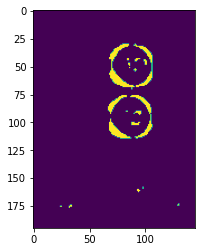

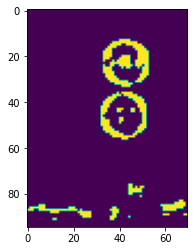

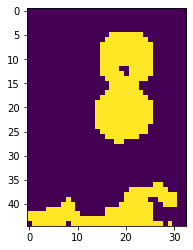

[INFO] Performing nms ... 


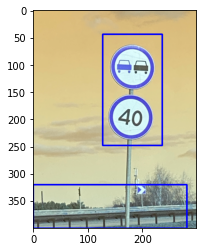

In [9]:
threshold = 0.5
nms_threshold = 0.3
scale_factor = 2.0
min_img_size = 48

# raw_img = ((train_images[18] * 127.5 ) + 127.5).astype(np.uint8)
raw_img = cv2.imread(os.path.join(train_dir, 'road726.png'))
# raw_img = cv2.imread('test.png')
H, W = raw_img.shape[:2]

images = [raw_img]
current_h, current_w = raw_img.shape[:2]
while(current_h > min_img_size and current_w > min_img_size):
    current_h = int(current_h / scale_factor)
    current_w = int(current_w / scale_factor)
    
    if(current_w < min_img_size or current_h < min_img_size) : break
    
    image = cv2.resize(raw_img, (current_w, current_h))
    images.append(image)
    
boxes = []
for i, image in enumerate(images):
    if(i == 0): scale = 1
    else : scale = scale_factor ** i
        
    img = (image - 127.5) / 127.5
    height, width = image.shape[:2]

    predictions = pnet.predict(np.array([img]))
    features_shape = predictions[1][0].shape[:2]
    
    scale_w = width / features_shape[1]
    scale_h = height / features_shape[0]
    
    bboxes = predictions[1][0]
    raw_bboxes = bboxes
    confidence = predictions[0][0]

    ### Showing confidence map ###
    conf_map = confidence[:, :, 1]
    conf_map[conf_map > 0.7] = 255
    conf_map[conf_map <= 0.7] = 0
    conf_map = (conf_map * 255).astype(np.uint8)
    contours, hierarchy = cv2.findContours(conf_map, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    for contour in contours:
        rect = cv2.boundingRect(contour)
        x, y, w, h = (rect * np.array([W/conf_map.shape[1],H/conf_map.shape[0],W/conf_map.shape[1],H/conf_map.shape[0] ])).astype(int)
        
        if(w * h < (W * H)/64): continue
        boxes.append([x,y,w,h])
        
    plt.imshow(conf_map)
    plt.show()
        
print('[INFO] Performing nms ... ')
pick = __nms(np.array(boxes), np.ones((len(boxes))), nms_threshold, 'Min')
for i in pick:#range(len(boxes)):
    x,y,w,h = boxes[i]
    cv2.rectangle(raw_img, (x,y), (x+w, y+h), (0,0,255),2)

plt.imshow(raw_img)
plt.show()